In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import os.path as osp
import glob
import os

In [13]:
def create_circular(h, w, max_numb=None, center=None, tolerance=1, min_val=0):
    if center is None:  # use the middle of the image
        center = (w / 2 - 0.5, h / 2 - 0.5)
    if max_numb is None:
        max_numb = max(h//2, w//2)

    dist_from_center = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            dist_from_center[i][j] = int(max(abs(i - center[0]), abs(j-center[1]))//tolerance + min_val)
    return dist_from_center

In [3]:
data.shape[-1]

NameError: name 'data' is not defined

In [64]:
data = [i for i in range(8*8)]
data = np.array(data).reshape((8,8))

In [60]:
data = np.random.randint(255, size=(32, 32))

In [ ]:
data

In [3]:
# Get fourier batches
def split_tensor(imgs, split_coefs=None):
    if split_coefs is None:
        split_coefs = [1, 2, 4]
    result = []

    *_, h, w = imgs.shape
    for coef in split_coefs:
        step = h // coef
        # add fft
        for y in range(0, w, step):
            for x in range(0, h, step):
                value = torch.log(1 + torch.abs(torch.fft.fftshift(torch.fft.fft2(imgs[..., x:x + step, y:y + step]))))
                value -= value.min()
                value /= value.max()
                result.append(value)

    return result

In [4]:
def reshape_2d(array, border_size):
    ptr_st, ptr_end = border_size, len(array) - border_size
    data1 = list(array[:ptr_st])
    data2 = list(array[ptr_end:])
    itt_leng = 4
    while ptr_st != ptr_end:
        if itt_leng > 2:
            data1.append(array[ptr_st])
        else:
            data2.append(array[ptr_st])
        ptr_st += 1
        itt_leng -= 1
        if itt_leng == 0:
            itt_leng = 4
    return np.stack([data1, data2])

In [5]:
import torch
from torch import nn

In [6]:
class ConvAutoEncoder(torch.nn.Module):
    def __init__(self, band_length, out_features:int, in_channels=1, hidden=16, kernel=2):
        super().__init__()
        self.encoder = nn.Conv2d(in_channels, hidden, kernel = kernel)
        self.decoder = nn.Linear(hidden * (band_legnth - 1), out_features)
    
    def forward(self, X):
        return self.decoder(nn.ReLU(self.encoder(X)))    
                            
class LinearAutoEncoder(torch.nn.Module):
    def __init__(self, features: int, hidden: int, out_features:int):
        super().__init__()
        self.encoder = nn.Linear(features, hidden)
        self.decoder = nn.Linear(hidden, features)

    def forward(self, X):
        return self.decoder(nn.ReLU(self.encoder(X)))

In [6]:
# Get fourier batches 
def split_tensor(imgs, split_coefs=None):
    if split_coefs is None:
        split_coefs = [1, 2, 4]
    result = []

    *_, h, w = imgs.shape
    last_val = 0
    for coef in split_coefs:
        step = h // coef
        # add fft
        row_data = []
        for y in range(0, w, step):
            step_result = []
            for x in range(0, h, step):
                #temperory unused
                value = imgs[x:x + step, y:y + step]
                mask = create_circular(step, step, min_val=last_val)
                last_val = mask[-1][-1] + 1
                                
                
                step_result.append(mask)
            row_data.append(np.concatenate(step_result, axis=1))
        result.append(np.concatenate(row_data, axis=0)) 
    return result


In [8]:
result = split_tensor(data)

NameError: name 'data' is not defined

In [9]:
result

NameError: name 'result' is not defined

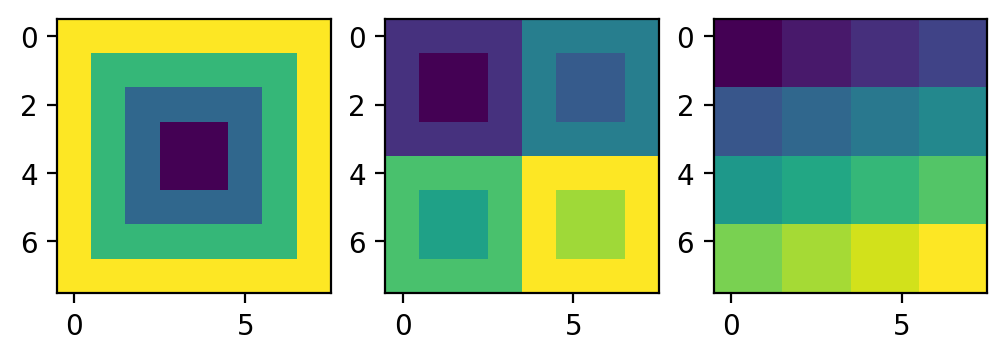

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=200)
ax1.imshow(result[0])
ax2.imshow(result[1])
ax3.imshow(result[2])

In [ ]:
vert_amount = int(result[2][-1][-1]+1)
adj_matrix = np.zeros((vert_amount,vert_amount)).astype(int)
gl_map, gen_map, loc_map = result[0].astype(int), result[1].astype(int), result[2].astype(int)
for gl, gen, loc in np.nditer([gl_map, gen_map, loc_map]):
    adj_matrix[gl, gen] = 1
    adj_matrix[gl, loc] = 1
    adj_matrix[gen, loc] = 1

In [ ]:
plt.imshow(adj_matrix)

In [12]:
# Feature extraction

In [13]:
class ConvAutoEncoder(torch.nn.Module):
    def __init__(self, band_length, out_features:int, in_channels=1, hidden=16, kernel=2):
        super().__init__()
        self.encoder = nn.Conv2d(in_channels, hidden, kernel_size = kernel)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(hidden * (band_length), out_features)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.relu(x).flatten()
        return self.decoder(x)
                            
class LinearAutoEncoder(torch.nn.Module):
    def __init__(self, features: int, hidden: int, out_features:int):
        super().__init__()
        self.encoder = nn.Linear(features, hidden)
        self.relu=nn.ReLU()
        self.decoder = nn.Linear(hidden, features)

    def forward(self, x):
        x = self.encoder(x)
        x = self.relu(x)
        return self.decoder(x)

In [14]:
##Create ModuleList
def create_layers(img_shape, split_coefs=None, hidden=16, out=10, tp = 'linear'):
    layers = nn.ModuleList()

    if split_coefs is None:
        split_coefs = [1, 2, 4]

    for coef in split_coefs:
        #Add simular pieces
        for _ in range(coef**2):
            input_layers = 4 if tp=='linear' else 1
            for _ in range(img_shape//(2  * coef)):
                #Linear
                if tp == 'linear':
                    layers.append(LinearAutoEncoder(input_layers, hidden, out))
                    input_layers += 8
                elif tp == 'conv':
                    layers.append(ConvAutoEncoder(input_layers, out, hidden=hidden))
                    input_layers += 4

    return layers

##Create ModuleList
def create_border_leng(img_shape, split_coefs=None):
    border_leng = []

    if split_coefs is None:
        split_coefs = [1, 2, 4]

    for coef in split_coefs:
        #Add simular pieces
        for _ in range(coef**2):
            inp = 2
            for _ in range(img_shape//(2 * coef)):
                border_leng.append(inp)
                inp += 2
                
    return border_leng

In [2]:
min_value = 0 
NEURAL_TYPE = 'conv'
layers = create_layers(data.shape[-1], tp=NEURAL_TYPE)
if NEURAL_TYPE == 'conv':
    border = create_border_leng(data.shape[-1])
node_embeddings = []

for value_map in result:
    max_value = value_map[-1][-1].astype(int)
    for rad in range(min_value, max_value+1):
        values = data[value_map == rad]
        if NEURAL_TYPE == 'linear':
            values = torch.from_numpy(values).float()
            node_embeddings.append(layers[rad](values))
        elif NEURAL_TYPE == 'conv':
            values2d = torch.from_numpy(reshape_2d(values, border[rad])).float()
            values2d = values2d.unsqueeze(0)
            node_embeddings.append(layers[rad](values2d))
    min_value = max_value + 1


NameError: name 'create_layers' is not defined

In [16]:
from torch_geometric.nn import global_mean_pool

In [2]:
# Get fourier batches
from PIL import Image

def normalization(value):
    value -= value.min()
    value /= value.max()
    return value

def split_array(imgs, split_coefs=None):
    if split_coefs is None:
        split_coefs = [1, 2, 4]
    fin_res_am = []
    fin_res_ph = []
    
    *_, h, w = imgs.shape
    for coef in split_coefs:
        row_data_amp = []
        row_data_ph = []
        step = h // coef
        # add fft
        try:
            for y in range(0, w, step):
                result_amp = []
                result_ph = []
                for x in range(0, h, step):
                    fft_data = np.fft.fftshift(np.fft.fft2(imgs[..., x:x + step, y:y + step]))
                    amp_val, ph_val = np.abs(fft_data), np.angle(fft_data)
                    amp_val = np.log(1 +  amp_val) #??
                    amp_val, ph_val = normalization(amp_val), normalization(ph_val)
                    result_amp.append(amp_val)
                    result_ph.append(ph_val)

                row_data_amp.append(np.concatenate(result_amp, axis=1))
                row_data_ph.append(np.concatenate(result_ph, axis=1))
        except:
            print(x, y)
        fin_res_am.append(np.concatenate(row_data_amp, axis=0)) 
        fin_res_ph.append(np.concatenate(row_data_ph, axis=0)) 
    return fin_res_am, fin_res_ph


In [3]:
from tqdm import tqdm
import os
from pathlib import Path
import glob
import numpy as np
bad_files = ['/raid/data/cats_dogs_dataset/PetImages/Cat/666.jpg', '/raid/data/cats_dogs_dataset/PetImages/Cat/Thumbs.db',
            '/raid/data/cats_dogs_dataset/PetImages/Dog/Thumbs.db', '/raid/data/cats_dogs_dataset/PetImages/Dog/11702.jpg',]

def dataset_preprocessing(directory, type_list=[('NORMAL', 0), ('PNEUMONIA', 1)],
                          img_shape=(256, 256), target_dirname='preprocessed'):
    result_data = []
    # if not os.path.exists(f'/raid/data/cats_dogs_dataset/{target_dirname}'):
        # os.mkdir(f'/raid/data/cats_dogs_dataset/{target_dirname}')
    if not os.path.exists(f'/raid/data/chest_xray/{target_dirname}'):
        os.mkdir(f'/raid/data/chest_xray/{target_dirname}')


    for dir_name, target_type in type_list:
        for file in tqdm(glob.glob(f'{directory}/{dir_name}/*')):
            if file in bad_files:
                continue
            data = np.array(Image.open(file).convert('L').resize(img_shape, Image.ANTIALIAS))
            try:
                data_amp, data_phase = split_tensor(data)
            except:
                bad_files.append(file)
                continue
            if not os.path.exists(f'/raid/data/chest_xray/{target_dirname}/{dir_name}'):
                os.mkdir(f'/raid/data/chest_xray/{target_dirname}/{dir_name}')
            # np.save(f'/raid/data/cats_dogs_dataset/{target_dirname}/{dir_name}/{Path(file).stem}.npy',
            #         [data_amp, data_phase, target_type])
            np.save(f'/raid/data/chest_xray/{target_dirname}/{dir_name}/{Path(file).stem}.npy',
                    [data_amp, data_phase, target_type])
# def dataset_preprocessing(directory, type_list=[('Cat', 0), ('Dog', 1)],
#                           img_shape=(256, 256), target_dirname='preprocessed'):
#     result_data = []
#     if not os.path.exists(f'/raid/data/cats_dogs_dataset/{target_dirname}'):
#         os.mkdir(f'/raid/data/cats_dogs_dataset/{target_dirname}')

#     for dir_name, target_type in type_list:
#         for file in tqdm(glob.glob(f'{directory}/{dir_name}/*')):
#             if file in bad_files:
#                 continue
#             data = np.array(Image.open(file).convert('L').resize(img_shape, Image.ANTIALIAS))
# #             try:
#             if file in bad_files:
#                 continue
#             data_amp, data_phase = split_array(data)
# #             except:
# #                 bad_files.append(file)
# #                 continue
#             if not os.path.exists(f'/raid/data/cats_dogs_dataset/{target_dirname}/{dir_name}'):
#                 os.mkdir(f'/raid/data/cats_dogs_dataset/{target_dirname}/{dir_name}')
#             np.save(f'/raid/data/cats_dogs_dataset/{target_dirname}/{dir_name}/{Path(file).stem}.npy',
#                     [data_amp, data_phase, target_type])

In [20]:
bad_files

['/raid/data/cats_dogs_dataset/PetImages/Cat/666.jpg',
 '/raid/data/cats_dogs_dataset/PetImages/Cat/Thumbs.db',
 '/raid/data/cats_dogs_dataset/PetImages/Dog/Thumbs.db',
 '/raid/data/cats_dogs_dataset/PetImages/Dog/11702.jpg']

In [5]:
!ls /raid/data/chest_xray

preprocessed_xray  processed  train


In [6]:
dataset_preprocessing('/raid/data/chest_xray/train', target_dirname='preprocessed_xray_circ')

  0%|                                                                                                                                                                              | 0/1583 [00:00<?, ?it/s]/tmp/ipykernel_9384/3852367431.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  data = np.array(Image.open(file).convert('L').resize(img_shape, Image.ANTIALIAS))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:47<00:00, 89.06it/s]


In [22]:
#CAT - 0, DOG - 1
import os
from pathlib import Path
import glob
import numpy as np
from PIL import Image
bad_files = ['/raid/data/cats_dogs_dataset/PetImages/Cat/666.jpg', '/raid/data/cats_dogs_dataset/PetImages/Cat/Thumbs.db',
            '/raid/data/cats_dogs_dataset/PetImages/Dog/Thumbs.db', '/raid/data/cats_dogs_dataset/PetImages/Dog/11702.jpg',]
def dataset_preprocessing(directory, type_list = [('Cat', 0) , ('Dog', 1)], img_shape=(256,256)):
    result_data = []
    if not os.path.exists(f'/raid/data/cats_dogs_dataset/{target_dirname}'):
        os.mkdir(f'/raid/data/cats_dogs_dataset/{target_dirname}')

    for dir_name, target_type in type_list:
        for file in glob.glob(f'{directory}/{dir_name}/*'):
            print(file)
            if file in bad_files:
                continue
            data = np.array(Image.open(file).convert('L').resize(img_shape, Image.ANTIALIAS))
            data_amp, data_phase = split_array(data)
            np.save(f'/raid/data/cats_dogs_dataset/preprocessed_circ_basic/{dir_name}/{Path(file).stem}.npy', 
                    [data_amp, data_phase, target_type])


In [27]:
dataset_preprocessing('/raid/data/cats_dogs_dataset/PetImages')


  0%|                                                                                                                                                                             | 0/12500 [00:00<?, ?it/s]/tmp/ipykernel_9177/3591442012.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  data = np.array(Image.open(file).convert('L').resize(img_shape, Image.ANTIALIAS))
  0%|                                                                                                                                                                             | 0/12500 [00:00<?, ?it/s]


NameError: name 'split_array' is not defined

In [20]:
!ls

GNN_img.ipynb  Untitled.ipynb  create_dataset_for_GNN.ipynb  main.py  wandb
MADE.ipynb     conf.yml        final_projects		     venv


In [21]:
def split_tensor(size, split_coefs=None):
    if split_coefs is None:
        split_coefs = [1, 2, 4]
    result = []

    last_val = 0
    for coef in split_coefs:
        step = size // coef
        # add fft
        row_data = []
        for y in range(0, size, step):
            step_result = []
            for x in range(0, size, step):
                #temperory unused
                mask = create_circular(step, step, min_val=last_val)
                last_val = mask[-1][-1] + 1
                step_result.append(mask)
            row_data.append(np.concatenate(step_result, axis=1))
        result.append(np.concatenate(row_data, axis=0)) 
    return result

In [58]:
SIZE = 256
global_map = split_tensor(SIZE)


class ConvAutoEncoder(torch.nn.Module):
    def __init__(self, band_length, out_features:int, in_channels=1, hidden=16, kernel=2):
        super().__init__()
        self.encoder = nn.Conv2d(in_channels, hidden, kernel = kernel)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(hidden * (band_legnth - 1), out_features)
    
    def forward(self, X):
        return self.decoder(self.relu(self.encoder(X)))    
                            
class LinearAutoEncoder(torch.nn.Module):
    def __init__(self, features: int, hidden: int, out_features:int):
        super().__init__()
        self.encoder = nn.Linear(features, hidden)
        self.relu = nn.ReLU()

        self.decoder = nn.Linear(hidden, out_features)

    def forward(self, X):
        return self.decoder(self.relu(self.encoder(X)))

def create_layers(img_shape, split_coefs=None, hidden=16, out=10, tp = 'linear'):
    layers = nn.ModuleList()

    if split_coefs is None:
        split_coefs = [1, 2, 4]

    for coef in split_coefs:
        #Add simular pieces
        for _ in range(coef**2):
            input_layers = 4 if tp=='linear' else 1
            for _ in range(img_shape//(2  * coef)):
                #Linear
                if tp == 'linear':
                    layers.append(LinearAutoEncoder(input_layers, hidden, out).to(device))
                    input_layers += 8
                elif tp == 'conv':
                    layers.append(ConvAutoEncoder(input_layers, out, hidden=hidden).to(device))
                    input_layers += 4

    return layers

def get_embedding(data, layers, border=None):
    result = []
    for batch in data:
        min_value = 0
        node_embeddings = []
        for data_map, value_map in zip(batch, global_map):
            value_map = value_map.astype(int)
            max_value = value_map[-1][-1].astype(int)
            
            for rad in range(min_value, max_value+1):
                values = torch.from_numpy(data_map[value_map == rad]).float().to(device)
                if NEURAL_TYPE == 'linear':
                    node_embeddings.append(layers[rad](values))
                elif NEURAL_TYPE == 'conv':
                    values2d = torch.from_numpy(reshape_2d(values, border[rad])).float()
                    values2d = values2d.unsqueeze(0)
                    node_embeddings.append(layers[rad](values2d))
            min_value = max_value + 1
        result.append(torch.stack(node_embeddings))
    return torch.stack(result)

def reshape_2d(array, border_size):
    ptr_st, ptr_end = border_size, len(array) - border_size
    data1 = list(array[:ptr_st])
    data2 = list(array[ptr_end:])
    itt_leng = 4
    while ptr_st != ptr_end:
        if itt_leng > 2:
            data1.append(array[ptr_st])
        else:
            data2.append(array[ptr_st])
        ptr_st += 1
        itt_leng -= 1
        if itt_leng == 0:
            itt_leng = 4
    return np.stack([data1, data2])

def create_border_leng(img_shape, split_coefs=None):
    border_leng = []

    if split_coefs is None:
        split_coefs = [1, 2, 4]
    for coef in split_coefs:
        #Add simular pieces
        for _ in range(coef**2):
            inp = 2
            for _ in range(img_shape//(2 * coef)):
                border_leng.append(inp)
                inp += 2

    return border_leng

In [23]:
def get_embedding(data, layers, border=None):
    min_value = 0 
    node_embeddings = []
    for data_map, value_map in zip(data, global_map):
        value_map = value_map.astype(int)
        max_value = value_map[-1][-1].astype(int)
        
        for rad in range(min_value, max_value+1):
            values = torch.from_numpy(data_map[value_map == rad]).float().to(device)
            if NEURAL_TYPE == 'linear':
                node_embeddings.append(layers[rad](values))
            elif NEURAL_TYPE == 'conv':
                values2d = torch.from_numpy(reshape_2d(values, border[rad])).float()
                values2d = values2d.unsqueeze(0)
                node_embeddings.append(layers[rad](values2d))
        min_value = max_value + 1
    return torch.stack(node_embeddings)

In [59]:
device = torch.device('cuda:2')

In [25]:
data.shape[-1]

NameError: name 'data' is not defined

In [48]:
SIZE = 256
NEURAL_TYPE = 'linear'
import torch.nn as nn
from torch_geometric.nn import GCNConv,SAGEConv
from torch_geometric.nn import global_mean_pool



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes, size=256, out=10, emb_type = 'linear'):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.neural_type = emb_type
#         
        self.layers = create_layers(size, tp=NEURAL_TYPE, out=out)
        
        if emb_type == 'conv':
            self.border = create_border_leng(data.shape[-1])
        else:
            self.border = None
        
        
        self.conv1 = SAGEConv(out, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)
        self.soft = nn.Softmax(dim=1)


    def forward(self, x, edge_index, batch):
        
        x = get_embedding(x, self.layers, self.border) # current linear
        x = x.view(2 * 896, -1)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        #x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        return self.soft(x)


In [49]:
model = GCN(num_classes=1, hidden_channels = 128, emb_type='linear')
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()


In [50]:
criterion(torch.tensor([[0.1,0.3]]), torch.tensor([0]))

tensor(0.7981)

In [11]:
def create_circular(h, w, max_numb=None, center=None, tolerance=1, min_val=0):
    if center is None:  # use the middle of the image
        center = (w / 2 - 0.5, h / 2 - 0.5)
    if max_numb is None:
        max_numb = max(h//2, w//2)

    dist_from_center = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            dist_from_center[i][j] = int(max(abs(i - center[0]), abs(j-center[1]))//tolerance + min_val)
    return dist_from_center

In [3]:
from torch_geometric.data import Dataset, download_url
from torch_geometric.data import Data

class MyOwnDataset(Dataset):
    def __init__(self, root, files_list, is_train, size=256, allow_loops=False, transform=None, pre_transform=None,
                 pre_filter=None):
        self.data = files_list
        self.allow_loops = allow_loops
        self.is_train = is_train
        # TODO fix this shit
        self.gl_count = 1750 if self.is_train else 750
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return []

    @property
    def num_nodes(self):
        return SIZE // 2 + SIZE // 4 * 4 + SIZE // 8 * 16

    @property
    def processed_file_names(self):
        return [f'data_{idx}_is_train_{self.is_train}_loops={self.allow_loops}.pt' for idx in range(self.gl_count)]

    def _create_cco_matrix(self):
        result = split_tensor(SIZE)
        vert_amount = int(result[2][-1][-1] + 1)
        adj_matrix = np.zeros((vert_amount, vert_amount)).astype(int)

        gl_map, gen_map, loc_map = result[0].astype(int), result[1].astype(int), result[2].astype(int)
        for gl, gen, loc in np.nditer([gl_map, gen_map, loc_map]):
            adj_matrix[gl, gen] = 1
            adj_matrix[gl, loc] = 1
            adj_matrix[gen, loc] = 1
            if self.allow_loops:
                adj_matrix[gl, gl] = 1
                adj_matrix[loc, loc] = 1
                adj_matrix[gen, gen] = 1

        source_nodes = []
        target_nodes = []
        edge_list = []
        for iy, ix in np.ndindex(adj_matrix.shape):
            if adj_matrix[iy, ix] == 1:
                source_nodes.append(ix)
                target_nodes.append(iy)

                # unweighted solution
                edge_list.append(1)

        return source_nodes, target_nodes, edge_list

    def process(self):
        idx = 0
        source_vert, target_vert, edge_list = self._create_cco_matrix()
        edge_idx = torch.tensor([source_vert, target_vert])

        # DEBUG ROW
        _, small_data = train_test_split(self.data, test_size=0.1, random_state=42)
        train_data, test_data = train_test_split(small_data, test_size=0.3, random_state=42)
        data = train_data if self.is_train else test_data

        for file in data:
            # Read data from `raw_path`.
            amp, phase, target = np.load(file, allow_pickle=True)

            # temporary only amp|
            data = Data(x=amp,
                        # edge_index=torch.tensor(edge_idx).clone().detach().float().requires_grad_(True),
                        edge_index=edge_idx,
                        edge_attrs=edge_list,
                        y=torch.tensor([target]))

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}_is_train_{self.is_train}_loops={self.allow_loops}.pt'))
            idx += 1
        self.gl_count = idx

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}_is_train_{self.is_train}_loops={self.allow_loops}.pt'))
        return data


In [12]:
save_root = '/raid/data/cats_dogs_dataset/'
files = glob.glob('/raid/data/cats_dogs_dataset/preprocessed/*/*.npy', recursive=True)
train_dataset = MyOwnDataset(save_root, files, is_train = True)
test_dataset = MyOwnDataset(save_root, files, is_train = False)

NameError: name 'glob' is not defined

In [ ]:
device = torch.device('cpu')

In [5]:
from torch_geometric.loader import DataLoader

device = torch.device('cpu')
save_root = '/raid/data/cats_dogs_dataset/'
files = glob.glob('/raid/data/cats_dogs_dataset/preprocessed/*/*.npy', recursive=True)
train_dataset = MyOwnDataset(save_root, files, is_train = True)
test_dataset = MyOwnDataset(save_root, files, is_train = False)

model = GCN(num_classes=2, hidden_channels = 10).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

NameError: name 'torch' is not defined

In [56]:
# import wandb

# wandb.init(project="GNN")

In [57]:
# weights_stem = 'GNN_Linear_No_loops_bsize=1'
# wandb.run.name = weights_stem


#                 experiment.log_metric("train_dice_loss", batch_loss.item(),
#                                       epoch=epoch_idx, step=step_counter[action])
def train():
    model.train()
    itt = 0
    for itt, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
#         out = model(data.x, data.edge_index, data.batch) 
        optimizer.zero_grad()  # Clear gradients.

        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        print(loss)

#         if itt % 100 == 0:
#             wandb.log({"train_cross_entropy_loss": loss.item()})
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

def test(loader):
    model.eval()
    correct = 0
    for itt, data in enumerate(loader):  # %ђIterate in batches over the training/test dataset.
        out = model(data.x[0], data.edge_index, data.batch) # Perform a single forward pass.
        data = data.to(device)
        pred = out.argmax(dim=1)# Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
#         correct += int((pred == data.y>.squeeze().unsqueeze(0).float()).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

best_train, cur_epoch, best_val = -1, -1, -1 
for epoch in range(1, 500):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    best_train, cur_epoch, best_val = (train_acc, epoch, test_acc) if test_acc > best_val \
                                    else (best_train, cur_epoch, best_val)
    wandb.log({'best train accuracy': best_train})
    wandb.log({'best test accuracy': best_val})
    
    wandb.log({'current train accuracy': train_acc})
    wandb.log({'current test accuracy': test_acc})

    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print(f'Best test accuracy - {best_val} on epoch {cur_epoch} with train accuracy - {best_train}')

tensor(0.6935, grad_fn=<NllLossBackward0>)
tensor(0.6934, grad_fn=<NllLossBackward0>)
tensor(0.6933, grad_fn=<NllLossBackward0>)
tensor(0.6933, grad_fn=<NllLossBackward0>)
tensor(0.7078, grad_fn=<NllLossBackward0>)
tensor(0.7055, grad_fn=<NllLossBackward0>)
tensor(0.6932, grad_fn=<NllLossBackward0>)
tensor(0.6932, grad_fn=<NllLossBackward0>)
tensor(0.6931, grad_fn=<NllLossBackward0>)
tensor(0.6975, grad_fn=<NllLossBackward0>)
tensor(0.6955, grad_fn=<NllLossBackward0>)
tensor(0.6931, grad_fn=<NllLossBackward0>)
tensor(0.6931, grad_fn=<NllLossBackward0>)
tensor(0.6969, grad_fn=<NllLossBackward0>)
tensor(0.6931, grad_fn=<NllLossBackward0>)
tensor(0.6879, grad_fn=<NllLossBackward0>)
tensor(0.6991, grad_fn=<NllLossBackward0>)
tensor(0.6931, grad_fn=<NllLossBackward0>)
tensor(0.7003, grad_fn=<NllLossBackward0>)
tensor(0.6998, grad_fn=<NllLossBackward0>)
tensor(0.6872, grad_fn=<NllLossBackward0>)
tensor(0.6931, grad_fn=<NllLossBackward0>)
tensor(0.6990, grad_fn=<NllLossBackward0>)
tensor(0.69

KeyboardInterrupt: 

In [ ]:
amp = np.load('/raid/data/cats_dogs_dataset/preprocessed/Cat/0.npy', allow_pickle=True)[0]

In [ ]:
result

In [ ]:
min_value = 0 
NEURAL_TYPE = 'conv'
layers = create_layers(data.shape[-1], tp=NEURAL_TYPE)
if NEURAL_TYPE == 'conv':
    border = create_border_leng(data.shape[-1])
node_embeddings = []

for value_map in result:
    max_value = value_map[-1][-1].astype(int)
    for rad in range(min_value, max_value+1):
        values = data[value_map == rad]
        if NEURAL_TYPE == 'linear':
            values = torch.from_numpy(values).float()
            node_embeddings.append(layers[rad](values))
        elif NEURAL_TYPE == 'conv':
            values2d = torch.from_numpy(reshape_2d(values, border[rad])).float()
            values2d = values2d.unsqueeze(0)
            node_embeddings.append(layers[rad](values2d))
    min_value = max_value + 1


In [2]:
!ls /raid/data/cats_dogs_dataset/PetImages

Cat  Dog


In [8]:
import torchvision

In [3]:
torchvision.datasets.ImageFolder(root='/raid/data/cats_dogs_dataset/PetImages')

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: /raid/data/cats_dogs_dataset/PetImages

In [5]:
import os
from tqdm import tqdm

In [6]:
def check_Image(path):
    return os.path.getsize(path) > 0

In [30]:
os.path.getsize('/raid/data/cats_dogs_dataset/PetImages/Cat/666.jpg')

0

In [7]:
!pip3 install torchvision


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [10]:
ls ../../chest_xray/train

NORMAL/  PNEUMONIA/


In [ ]:
ls

In [11]:
import torchvision.transforms as transforms
import torchvision
import os
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
_, small_data = train_test_split(torchvision.datasets.ImageFolder(root='/raid/data/cats_dogs_dataset/PetImages/', 
                                                                          is_valid_file=check_Image, transform=transform), test_size=0.5, random_state=42)

train_data, test_data = train_test_split(small_data, 
                                         test_size=0.3, random_state=42)


In [12]:

from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

batch_size=64
device = torch.device('cuda:0')

model = FreqNet(num_classes=2).to(device)


optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min')

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)


/tmp/ipykernel_12178/1513391733.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.weights)


In [13]:
print(sum(p.numel() for p in model.parameters()), 'sum')


397588 sum


In [ ]:
from tqdm import tqdm
def train():
    model.train()
    for itt, (data, label) in enumerate(train_loader):  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        data, label = data.to(device), label.to(device)
        out = model(data)  # Perform a single forward pass.
        loss = criterion(out, label)  # Compute the loss.

        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.


def test(loader):
    model.eval()
    correct = 0
    for itt, (data, label) in enumerate(loader):  # %Iterate in batches over the training/test dataset.
        data, label = data.to(device), label.to(device)
        out = model(data)  # Perform a single forward pass.
        data = data.to(device)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == label).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


best_train, cur_epoch, best_val = -1, -1, -1
for epoch in tqdm(range(1, 50)):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    scheduler.step(test_acc)
    best_train = train_acc if train_acc > best_train else best_train
    best_val = test_acc if test_acc > best_val else best_val

    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print(f'Best test accuracy - {best_val} on epoch {cur_epoch} with train accuracy -> {best_train}')


  2%|███▎                                                                                                                                                                 | 1/49 [02:39<2:07:58, 159.97s/it]

Epoch: 001, Train Acc: 0.5033, Test Acc: 0.4813


  4%|██████▋                                                                                                                                                              | 2/49 [05:18<2:04:47, 159.30s/it]

Epoch: 002, Train Acc: 0.4954, Test Acc: 0.4864


  6%|██████████                                                                                                                                                           | 3/49 [07:57<2:02:02, 159.19s/it]

Epoch: 003, Train Acc: 0.4987, Test Acc: 0.5051


  8%|█████████████▍                                                                                                                                                       | 4/49 [10:36<1:59:12, 158.94s/it]

Epoch: 004, Train Acc: 0.4987, Test Acc: 0.4984


 10%|████████████████▊                                                                                                                                                    | 5/49 [13:14<1:56:25, 158.76s/it]

Epoch: 005, Train Acc: 0.4973, Test Acc: 0.4928


 12%|████████████████████▏                                                                                                                                                | 6/49 [15:53<1:53:48, 158.79s/it]

Epoch: 006, Train Acc: 0.4926, Test Acc: 0.4832


 14%|███████████████████████▌                                                                                                                                             | 7/49 [18:32<1:51:03, 158.66s/it]

Epoch: 007, Train Acc: 0.4962, Test Acc: 0.5173


 16%|██████████████████████████▉                                                                                                                                          | 8/49 [21:10<1:48:19, 158.52s/it]

Epoch: 008, Train Acc: 0.5029, Test Acc: 0.4976


 18%|██████████████████████████████▎                                                                                                                                      | 9/49 [23:47<1:45:29, 158.23s/it]

Epoch: 009, Train Acc: 0.4940, Test Acc: 0.4987


 20%|█████████████████████████████████▍                                                                                                                                  | 10/49 [26:25<1:42:46, 158.12s/it]

Epoch: 010, Train Acc: 0.4949, Test Acc: 0.4955


 22%|████████████████████████████████████▊                                                                                                                               | 11/49 [29:03<1:40:02, 157.97s/it]

Epoch: 011, Train Acc: 0.4955, Test Acc: 0.4923


 24%|████████████████████████████████████████▏                                                                                                                           | 12/49 [31:41<1:37:28, 158.06s/it]

Epoch: 012, Train Acc: 0.5035, Test Acc: 0.4997


In [ ]:
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

import numpy as np
import torch
from torch import nn
from torchvision.transforms.functional import rgb_to_grayscale


class TrainableEltwiseLayer(nn.Module):
    def __init__(self, b, n):
        super(TrainableEltwiseLayer, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(b, n))  # define the trainable parameter
        self.model_init()

    def forward(self, x):
        # assuming x is of size b-1-h-w
        # print(x.shape)
        return x * self.weights  # element-wise multiplication

    def model_init(self):
        torch.nn.init.xavier_uniform(self.weights)
        self.weights.requires_grad = True


# Get fourier batches
def split_tensor(imgs, split_coefs=None):
    if split_coefs is None:
        split_coefs = [1, 2, 4]
    result = []

    *_, h, w = imgs.shape
    for coef in split_coefs:
        step = h // coef
        # add fft
        for y in range(0, w, step):
            for x in range(0, h, step):
                value = torch.log(1 + torch.abs(torch.fft.fftshift(torch.fft.fft2(imgs[..., x:x + step, y:y + step])))).to('cuda:0')
                value -= value.min()
                value /= value.max()
                result.append(value)
        #
        # tiles = [torch.abs(torch.fft.fftshift(torch.fft.fft2(imgs[..., x:x + step, y:y + step]))).to('cuda:0')
        #          for x in range(0, h, step) for y in range(0, w, step)]
        # tiles = [imgs[..., x:x + step, y:y + step].to('cuda:0')
        #          for x in range(0, h, step) for y in range(0, w, step)]
        # result.extend(tiles)

    return result


def create_circular(h, w, max_numb=None, center=None, tolerance=1):
    if center is None:  # use the middle of the image
        center = (w / 2 - 1/2, h / 2 - 1/2)

    dist_from_center = torch.zeros((h, w))
    for i in range(h):
        for j in range(w):
            dist_from_center[i][j] = max(abs(i - center[0]), abs(j - center[1])) // tolerance

    return dist_from_center.type(torch.float).to('cuda:0')


def get_summation(data_list, tolerance=2):
    data_dict = {}
    result = []
    for data in data_list:
        *_, h, w = data.shape

        if not (h, w) in data_dict:
            data_dict[(h, w)] = create_circular(h, w, tolerance=tolerance)
        data_map = data_dict[(h, w)]
        max_val = int(data_map[0][0])

        for i in range(max_val + 1):
            result.append(torch.sum(data * (data_map == i).float(), dim=(1, 2, 3)))
    return result


class FreqNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.ew_layer = TrainableEltwiseLayer(64, 784)

        self.linear = nn.Sequential(
            nn.ReLU(),
            nn.Linear(784, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Linear(392, 98),
            nn.BatchNorm1d(98),
            nn.ReLU(),
            nn.Linear(98, num_classes)
        )

        # self.sm = nn.functional.softmax
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        b, *_ = x.shape
        data = split_tensor(x, split_coefs=[1, 2, 4])

        x = get_summation(data, tolerance=1)

        x = torch.stack(x).permute(1, 0)

        logits = self.linear(self.ew_layer(x))


        return logits

In [37]:
out = model(data.x, data.edge_index, data.batch, batch_size)

NameError: name 'data' is not defined

In [4]:
import io
import pickle

import numpy as np
import torch
from sklearn.model_selection import train_test_split
import os.path as osp
from tqdm import tqdm
import wandb
from yaml import safe_load

import os
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Dataset, download_url
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch.optim.lr_scheduler import ReduceLROnPlateau
import glob
import networkx as nx

SIZE = 256
NEURAL_TYPE = 'linear'
device = torch.device('cuda:0')


def create_layers(img_shape, num_blocks=3, hidden=16, out=10, tp='linear', isoclines=16, div_val=4):
    layers = nn.ModuleList()

    split_coefs = [2 ** i for i in range(num_blocks)]
    for coef in split_coefs:
        # Add simular pieces, several times
        for _ in range(coef ** 2):
            input_layers = (img_shape ** 2) // (isoclines * coef ** 2)
            layers.append(LinearAutoEncoder(input_layers, hidden, out, div_val))
            if tp == 'linear':
                break
    return layers


class LinearAutoEncoder(torch.nn.Module):
    def __init__(self, features: int, hidden: int, out_features: int, div_val=4):
        super().__init__()
        self.layers = nn.Sequential()
        inp = features
        while inp // div_val > hidden:
            self.layers.append(nn.Linear(inp, inp // div_val))
            self.layers.append(nn.ReLU())
            inp = inp // div_val

        self.layers.append(nn.Linear(inp, hidden))
        self.layers.append(nn.ReLU())
        # self.relu = nn.ReLU()

        while inp * div_val < out_features:
            self.layers.append(nn.Linear(inp, inp * div_val))
            self.layers.append(nn.ReLU())
            inp *= div_val

        # self.decoder = nn.Linear(hidden, out_features)

    def forward(self, x):
        x = self.layers(x)
        # x = self.relu(x)
        # return self.decoder(x)
        return x


def get_long_embedding(data, layers, iso_amount=16, batch_size=2):
    node_embeddings = []
    for it_val, value in enumerate(data):
        value = value.reshape(batch_size, iso_amount, -1)
        for i in range(iso_amount):
            node_embeddings.append(layers[it_val](value[:, i, :]))
    return torch.stack(node_embeddings, dim=1)


def getPositionEncoding(seq_len, d, n=10000):
    P = torch.zeros((seq_len, d))
    for k in range(seq_len):
        for i in torch.arange(int(d / 2)):
            denominator = torch.pow(n, 2 * i / d)
            P[k, 2 * i] = torch.sin(k / denominator)
            P[k, 2 * i + 1] = torch.cos(k / denominator)
    return P


def get_embedding(data, layers, iso_amount=16, batch_size=2):
    node_embeddings = []
    for it_val, value in enumerate(data):
        value = value.reshape(batch_size, iso_amount, -1)
        if it_val == 0:
            layer_id = 0
        elif 1 <= it_val <= 4:
            layer_id = 1
        elif 5 <= it_val <= 21:
            layer_id = 2
        for i in range(iso_amount):
            node_embeddings.append(layers[layer_id](value[:, i, :]))

    return torch.stack(node_embeddings, dim=1)


def add_positional_encoding(embedding, iso_amount=16, emb_len=10):
    b, h, c = embedding.shape
    big_embed = torch.zeros(b, iso_amount, c)

    four_split_embed_func = getPositionEncoding(4, c)
    medium_embed = torch.cat([four_split_embed_func[i].unsqueeze(0).repeat(iso_amount, 1).unsqueeze(0).repeat(b, 1, 1)
                              for i in range(4)], dim=1)

    sixt_split_embed_func = getPositionEncoding(16, c)

    small_embed = torch.cat([sixt_split_embed_func[i].unsqueeze(0).repeat(iso_amount, 1).unsqueeze(0).repeat(b, 1, 1)
                             for i in range(16)], dim=1)
    positional_embed = torch.cat([big_embed, medium_embed, small_embed], dim=1).to(device)
    return embedding + positional_embed



class MyOwnDataset(Dataset):
    def __init__(self, root, files_list, is_train, size=256, allow_loops=False, transform=None, pre_transform=None,
                 pre_filter=None, iso_amount=16, split_amount=21):
        self.data = files_list
        self.allow_loops = allow_loops
        self.is_train = is_train
        root_path = Path(root)
        self._processed_dir = str(Path(root).parent) + '/processed_' + str(Path(root).name)
        # TODO fix this shit
        self.iso_amount = iso_amount
        self.split_amount = split_amount
        # 4099 and 1757
        # 15015579 sum
        # self.gl_count = 17407 if self.is_train else 7461
        self.gl_count = 5270 if self.is_train else 586

        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return []

    @property
    def num_nodes(self):
        return self.iso_amount * self.split_amount

    @property
    def processed_file_names(self):
        return [f'xdata_{idx}_is_train_{self.is_train}_loops={self.allow_loops}_isoc={self.iso_amount}' \
                f'_split={self.split_amount}.pt' for idx in range(self.gl_count)]

    def _create_cco_matrix(self):
        vert_amount = int(self.iso_amount * self.split_amount)

        adj_matrix = np.zeros((vert_amount, vert_amount))
        for i in range(vert_amount - 1):
            if self.allow_loops:
                adj_matrix[i][i] = nn.Parameter(1)
                # adj_matrix[i][i] = nn.Parameter(torch.tensor(1.0))
            if i % self.iso_amount != 1:
                # adj_matrix[i][i + 1] = nn.Parameter(torch.tensor(1.0))
                adj_matrix[i][i + 1] = 1
            for j in range(self.split_amount):
                if self.iso_amount * j + i < vert_amount:
                    # adj_matrix[i][self.iso_amount * j + i] = nn.Parameter(torch.tensor(1.0))
                    adj_matrix[i][self.iso_amount * j + i] = 1
                else:
                    break

        source_nodes = []
        target_nodes = []
        edge_list = []
        for iy, ix in np.ndindex(adj_matrix.shape):
            # small changes
            if adj_matrix[iy, ix] != 0:
                source_nodes.append(ix)
                target_nodes.append(iy)
                edge_list.append(1.0)
            # edge_list.append(adj_matrix[iy, ix])
            # if adj_matrix[iy, ix] != 0:
                # unweighted solution
                # edge_list.append(1.0)
        return source_nodes, target_nodes, edge_list

    def process(self):
        idx = 0
        source_vert, target_vert, edge_list = self._create_cco_matrix()
        edge_idx = torch.tensor([source_vert, target_vert])
        # DEBUG ROW
        _, small_data = train_test_split(self.data, test_size=0.1, random_state=42)
#         small_data = self.data
        train_data, test_data = train_test_split(small_data, test_size=0.1, random_state=42)
        data = train_data if self.is_train else test_data
        # p;rint(edge_list)

        for file in data:
            # if os.path.exists(osp.join(self.processed_dir,
            #                               f'data_{idx}_is_train_{self.is_train}_loops={self.allow_loops}'
            #                               f'_isoc={self.iso_amount}_split={self.split_amount}.pt')):
            #     print('skip')
                # continue
            # Read data from `raw_path`.
            amp, phase, target = np.load(file, allow_pickle=True)
            try:
                amp = [torch.tensor(item).float() for item in amp]
                # lst = [torch.from_numpy(item).float() for item in lst]

                # temporary only amp|
                data = Data(x=amp,
                            # edge_index=torch.tensor(edge_idx).clone().detach().float().requires_grad_(True),
                            edge_index=edge_idx,
                            edge_attr=edge_list,
                            y=torch.tensor([target]))
                torch.save(data, osp.join(self.processed_dir,
                                          f'xdata_{idx}_is_train_{self.is_train}_loops={self.allow_loops}'
                                          f'_isoc={self.iso_amount}_split={self.split_amount}.pt'))

                idx += 1
            except:
                continue
        self.gl_count = idx
        print(self.gl_count)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(
            osp.join(self.processed_dir,
                     f'xdata_{idx}_is_train_{self.is_train}_loops={self.allow_loops}'
                     f'_isoc={self.iso_amount}_split={self.split_amount}.pt'))

        return data


class GraphInformation:
    def __init__(self, graph_struct):
        self.max_val = 0
        self.graph_struct = graph_struct.detach().cpu().numpy()
        self.adj_matrix = self._get_adj()
        self.G = nx.from_numpy_array(self.adj_matrix)


    def _get_adj(self):
        _, edge_amount = self.graph_struct.shape
        self.max_val = np.amax(self.graph_struct)
        adj_matrix = np.zeros((self.max_val + 1,  self.max_val + 1))
        for i in range(edge_amount):
            x, y = self.graph_struct[..., i]
            adj_matrix[x][y] = 1
            adj_matrix[y][x] = 1
        return adj_matrix


    def get_adj_view(self, connectivity_array):
        _, edge_amount = self.graph_struct.shape
        image = np.zeros((self.max_val + 1,  self.max_val + 1))
        for i in range(edge_amount):
            x, y = self.graph_struct[..., i]
            image[x][y] = connectivity_array[i]
        return image

    def get_matrix_view(self, connectivity_array):
        colors = []
        for i, j in self.G.edges():
            colors.append(connectivity_array[i][j].item())

        im_io = io.BytesIO()
        fig, ax = plt.subplots()

        nx.draw_circular(self.G, ax=ax, edge_color=colors)
        fig.savefig(im_io, format='png')
        return Image.open(im_io)



def get_config(path):
    with open(path, 'r') as stream:
        config = safe_load(stream)
    return config


config = get_config('diploma/conf.yml')
train_params = config['train_params']
model_params = config['model']
files_params = config['files_params']

device = torch.device(f'cuda:{train_params["device_num"]}')
batch_size = config['train_params']['batch_size']

save_root = files_params['save_root']
files = glob.glob(files_params['path_to_files'], recursive=True)

train_dataset = MyOwnDataset(save_root, files, is_train=True, iso_amount=model_params['iso_amount'],
                             split_amount=21 if model_params['num_blocks'] == 3 else 85)
test_dataset = MyOwnDataset(save_root, files, is_train=False, iso_amount=model_params['iso_amount'],
                            split_amount=21 if model_params['num_blocks'] == 3 else 85)
graph = train_dataset[0].edge_attr

model = GNN(num_classes=2, hidden_encoder=model_params['hidden_encoder_embed'], edge_weight=graph,
            hidden_GCN=model_params['hidden_GCN_embed'], encoder_out=model_params['encoder_out'],
            emb_type=model_params['emb_type'], div_val=model_params['div_val'],
            is_pos_embed=model_params['pos_embed'], depth=model_params['depth'],
            num_blocks=model_params['num_blocks'], iso_amount=model_params['iso_amount'],
            b_size=train_params['batch_size'], is_edges_trainable=model_params['is_edges_trainable']).to(device)
# print(model.parameters)
# for name, param in model.named_parameters():
    # print(name, param.shape, param.numel())
print(sum(p.numel() for p in model.parameters()), 'sum')
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

GraphLogger = GraphInformation(train_dataset[0].edge_index) if model_params['is_edges_trainable'] else None
adj_hist, adj_counter = [], 0

def train():

    model.train()
    for itt, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.

        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, batch_size)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.

        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.



def test(loader):
    model.eval()
    correct = 0

    for itt, data in enumerate(loader):  # %Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch, batch_size)  # Perform a single forward pass.
        data = data.to(device)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    # adj_view = GraphLogger.get_adj_view(model.edge_weight.detach())
    #
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


best_train, cur_epoch, best_val = -1, -1, -1
for epoch in tqdm(range(1, 50)):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    scheduler.step(test_acc)
    best_train = train_acc if train_acc > best_train else best_train
    best_val = test_acc if test_acc > best_val else best_val


    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print(f'Best test accuracy - {best_val} on epoch {cur_epoch} with train accuracy -> {best_train}')


Processing...
/tmp/ipykernel_36967/3437103213.py:211: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  amp = [torch.tensor(item).float() for item in amp]


2238


Done!
Processing...


249


Done!


15015579 sum


  0%|                                                                                                                                                                                | 0/49 [00:00<?, ?it/s]/home/v_shaposhnikov/.local/lib/python3.9/site-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'y', 'edge_attr', 'edge_index', 'x'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor(4009., device='cuda:1', grad_fn=<AddBackward0>)
tensor(4010.1028, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4011.0566, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4012.3276, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4013.4641, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4013.9331, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4014.7014, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4015.3340, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4015.2693, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4014.9746, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4014.6628, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4014.6511, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4015.1389, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4015.4143, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4015.4956, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4015.7239, device='cuda:1', grad_fn=<AddBackward0>)
tensor(4015.8716, device='cuda:1', grad_fn=<AddBackward0>)
t

  2%|███▍                                                                                                                                                                  | 1/49 [01:38<1:19:01, 98.79s/it]

Epoch: 001, Train Acc: 0.5183, Test Acc: 0.5462
tensor(4016.3850, device='cuda:1', grad_fn=<AddBackward0>)


  2%|███▎                                                                                                                                                                 | 1/49 [01:40<1:20:35, 100.73s/it]


KeyboardInterrupt: 

In [10]:
model.edge_weight.shape

torch.Size([4009])

In [15]:
print(data.edge_index[0][:4009])
print(data.edge_index[1][:4009])

tensor([  0,   1,  16,  ..., 334, 334, 335], device='cuda:1')
tensor([  0,   0,   0,  ..., 333, 334, 334], device='cuda:1')


In [24]:
x, y = data.edge_index[:4009]

In [27]:
for (x, y) in data.edge_index[:4009]:
    print(x, y)

ValueError: too many values to unpack (expected 2)

In [30]:
dict_vals = {}
for pos, (x, y) in enumerate(zip(data.edge_index[0][:4009], data.edge_index[1][:4009])):
    dict_vals[(x.item(), y.item())] = model.edge_weight[pos].item()

In [44]:
with open('diploma/dicts/dct_isoclines_hid=256_out=512_enc=256.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [47]:
loaded_dict

{(287, 271): 1.0496597290039062,
 (177, 176): 1.038428544998169,
 (223, 207): 1.0378994941711426,
 (209, 208): 1.036803126335144,
 (257, 256): 1.0346049070358276,
 (335, 319): 1.033868670463562,
 (287, 255): 1.0338099002838135,
 (273, 272): 1.033699870109558,
 (241, 240): 1.033613920211792,
 (287, 287): 1.0326157808303833,
 (289, 273): 1.0325384140014648,
 (271, 271): 1.0323714017868042,
 (223, 223): 1.031805396080017,
 (335, 303): 1.0312334299087524,
 (193, 192): 1.0310077667236328,
 (287, 239): 1.0308737754821777,
 (223, 191): 1.030660629272461,
 (257, 257): 1.0306452512741089,
 (209, 209): 1.030386209487915,
 (319, 319): 1.0303577184677124,
 (256, 256): 1.0296953916549683,
 (303, 303): 1.0295610427856445,
 (177, 161): 1.0295510292053223,
 (257, 241): 1.0294208526611328,
 (321, 320): 1.0292924642562866,
 (334, 318): 1.0289602279663086,
 (241, 241): 1.0288432836532593,
 (305, 304): 1.0286391973495483,
 (304, 304): 1.0282412767410278,
 (305, 305): 1.0280476808547974,
 (319, 303): 1.027

In [39]:
222 / 16

13.875

In [38]:

dict(sorted(dict_vals.items(), key=lambda item: item[1], reverse=True))


{(222, 222): 1.01083242893219,
 (223, 222): 1.0106792449951172,
 (211, 211): 1.0106325149536133,
 (212, 211): 1.0105767250061035,
 (212, 212): 1.0105624198913574,
 (217, 217): 1.01055908203125,
 (225, 193): 1.0105476379394531,
 (218, 217): 1.01052987575531,
 (216, 216): 1.0105193853378296,
 (213, 212): 1.0105186700820923,
 (218, 218): 1.0105125904083252,
 (215, 215): 1.0105113983154297,
 (221, 221): 1.0105092525482178,
 (213, 213): 1.0105016231536865,
 (222, 221): 1.010494351387024,
 (217, 216): 1.010489821434021,
 (220, 220): 1.01048743724823,
 (219, 218): 1.0104867219924927,
 (219, 219): 1.0104838609695435,
 (216, 215): 1.0104776620864868,
 (214, 214): 1.0104737281799316,
 (223, 223): 1.0104681253433228,
 (221, 220): 1.0104604959487915,
 (220, 219): 1.010460376739502,
 (214, 213): 1.0104600191116333,
 (215, 214): 1.0104374885559082,
 (273, 241): 1.0101580619812012,
 (208, 208): 1.0100829601287842,
 (272, 240): 1.0099990367889404,
 (210, 210): 1.0099852085113525,
 (211, 210): 1.009911

In [2]:
class GNN(torch.nn.Module):

    def __init__(self, hidden_encoder, hidden_GCN, num_classes, edge_weight, size=256,
                 encoder_out=10, emb_type='linear', div_val=2, is_pos_embed='full', depth=1,
                 num_blocks=3, iso_amount=16, b_size=60, is_edges_trainable=True):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.is_pos_embed = is_pos_embed.lower()
        self.depth = depth
        self.enc_out = encoder_out
        self.emb_type = emb_type
        self.b_size = b_size
        self.iso_amount = iso_amount
        self.edge_weight = nn.Parameter(torch.tensor([float(ed) for ed in edge_weight])) if is_edges_trainable else None


        if depth not in [1, 2]:
            raise ValueError

        self.layers = create_layers(size, num_blocks=num_blocks, hidden=hidden_encoder, tp=emb_type,
                                    out=encoder_out, div_val=div_val, isoclines=self.iso_amount)
        self.pos_embed = nn.Parameter(torch.zeros(b_size, 21 * self.iso_amount, hidden_encoder))
        # self.conv1 = SAGEConv(hidden_GCN, hidden_GCN)
        self.conv1 = GCNConv(hidden_GCN, hidden_GCN)
        if depth == 2:
            self.conv2 = GCNConv(hidden_GCN, hidden_GCN)
        self.lin = nn.Linear(hidden_GCN, num_classes)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x, edge_index, batch, batch_size):
        if self.emb_type == 'linear':
            x = get_embedding(x, self.layers, iso_amount=self.iso_amount, batch_size=batch_size)  # current linear
        elif self.emb_type == 'long':
            x = get_long_embedding(x, self.layers, iso_amount=self.iso_amount, batch_size=batch_size)

        if self.is_pos_embed == 'only_train':
            x = add_positional_encoding(x, emb_len=self.enc_out)
        elif self.is_pos_embed == 'only_param':
            x += self.pos_embed
        elif self.is_pos_embed == 'full':
            x = add_positional_encoding(x, emb_len=self.enc_out) + self.pos_embed
        # Maybe add this in get_embedding?
        print(sum(self.edge_weight))
        x = x.view(batch_size * 21 * self.iso_amount, -1)
        edges = self.edge_weight.repeat(self.b_size).sigmoid() if self.edge_weight is not None else None
        x = self.conv1(x, edge_index, edges)
        # x = self.conv1(x, edge_index)
        x = x.relu()
        if self.depth == 2:
            x = self.conv2(x, edge_index, edges)
            # x = self.conv2(x, edge_index)
            x = x.relu()
        # x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        return self.soft(x)

In [8]:
for itt, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
    optimizer.zero_grad()  # Clear gradients.

    data = data.to(device)
    out = model(data.x, data.edge_index, data.batch, batch_size)  # Perform a single forward pass.
    print(out)
    break
    loss = criterion(out, data.y)  # Compute the loss.

tensor(4016.0627, device='cuda:1', grad_fn=<AddBackward0>)
tensor([[0.5357, 0.4643],
        [0.5221, 0.4779],
        [0.5309, 0.4691],
        [0.5444, 0.4556],
        [0.5377, 0.4623],
        [0.5220, 0.4780],
        [0.5375, 0.4625],
        [0.5177, 0.4823],
        [0.5452, 0.4548],
        [0.5431, 0.4569],
        [0.5458, 0.4542],
        [0.5424, 0.4576],
        [0.5228, 0.4772],
        [0.5427, 0.4573],
        [0.5405, 0.4595],
        [0.5366, 0.4634],
        [0.5338, 0.4662],
        [0.5433, 0.4567],
        [0.5248, 0.4752],
        [0.5423, 0.4577],
        [0.5275, 0.4725],
        [0.5352, 0.4648],
        [0.5322, 0.4678],
        [0.5396, 0.4604],
        [0.5417, 0.4583],
        [0.5405, 0.4595],
        [0.5200, 0.4800],
        [0.5443, 0.4557],
        [0.5335, 0.4665],
        [0.5470, 0.4530],
        [0.5484, 0.4516],
        [0.5322, 0.4678],
        [0.5336, 0.4664],
        [0.5320, 0.4680],
        [0.5384, 0.4616],
        [0.5357, 0.4643],
     

In [42]:
# get_res()

In [14]:
!ls diploma

 GNN_isoclines.ipynb	       conf.yml		   main.py     preprocessing.py
'Positional embedding.ipynb'   full_isoclines.py   nohup.out   test.py
 circle.py		       isoclines.py	   pickles     wandb


In [23]:
!cat diploma/conf.yml

model:
  model_type: 'GCNConv'
  hidden_encoder_embed: 16
  hidden_GCN_embed: 16
  encoder_out: 8
  allow_loops: True
  #linear, long
  emb_type: 'linear'
  div_val: 2
  #none, only_train, only_param, full
  pos_embed: 'only_param'
  depth: 2
  #Experiment with long embed
  num_blocks: 3
  iso_amount: 16
  is_edges_trainable: True
  suffix: log

train_params:
  batch_size: 60
  device_num: 1
#  'online', 'offline', 'disabled'
  wandb_mode: 'online'
# CURRENT ON LOGS DATA
files_params:
  save_root: '/raid/data/chest_xray/'
  path_to_files: '/raid/data/cats_dogs_dataset/preprocessed/*/*.npy'

exp_name: 'Circle'


In [16]:
from torch_geometric.nn import GCNConv, GINConv, global_max_pool
from torch_geometric.explain import Explainer, GNNExplainer

In [76]:
model

GNN(
  (layers): ModuleList(
    (0): LinearAutoEncoder(
      (layers): Sequential(
        (0): Linear(in_features=4096, out_features=2048, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2048, out_features=1024, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1024, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=256, bias=True)
        (7): ReLU()
        (8): Linear(in_features=256, out_features=128, bias=True)
        (9): ReLU()
        (10): Linear(in_features=128, out_features=64, bias=True)
        (11): ReLU()
        (12): Linear(in_features=64, out_features=32, bias=True)
        (13): ReLU()
        (14): Linear(in_features=32, out_features=16, bias=True)
        (15): ReLU()
      )
    )
    (1): LinearAutoEncoder(
      (layers): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True

In [6]:
x = get_long_embedding(data.x, model.layers, iso_amount=model.iso_amount, batch_size=60)  # current linear

In [87]:
edges = model.edge_weight.repeat(model.b_size).sigmoid() if model.edge_weight is not None else None


In [88]:
edges

tensor([0.7298, 0.7266, 0.7294,  ..., 0.7302, 0.7303, 0.7303], device='cuda:1',
       grad_fn=<SigmoidBackward0>)

In [9]:
from copy import deepcopy

In [126]:
x = model.conv1

In [127]:
type(x)

torch_geometric.nn.conv.gcn_conv.GCNConv

In [128]:
y = deepcopy(x)

In [129]:
type(y)

torch_geometric.nn.conv.gcn_conv.GCNConv

In [21]:
model = model.to('cpu')

In [35]:
class GNN_expl(torch.nn.Module):

    def __init__(self, model):
        super(GNN_expl, self).__init__()
        self.conv1 = deepcopy(model.conv1)
        self.conv2 = deepcopy(model.conv2)
        print(self.conv2)
        self.lin = deepcopy(model.lin)
        print(self.lin)
        

    def forward(self, x, edge_index, batch, b_size=60):
        x = x.view(b_size * 21 * 16, -1)
        edges = model.edge_weight.repeat(b_size).sigmoid() if model.edge_weight is not None else None
        x = self.conv1(x, edge_index, edges)
        x = x.relu()
        x = self.conv2(x, edge_index, edges)
        x = x.relu()
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = F.dropout(x, p=0.1, training=Tr)
        x = self.lin(x)
        return self.soft(x)

In [36]:
md = GNN_expl(model)

GCNConv(16, 16)
Linear(in_features=16, out_features=2, bias=True)


In [30]:
# x

In [31]:
# x = get_long_embedding(data.x, model.layers, iso_amount=model.iso_amount, batch_size=60)  # current linear

In [34]:
print(x.shape)

torch.Size([60, 336, 16])


In [37]:
# md = md.to(device)
md(x.to('cpu'), data.edge_index.to('cpu'), batch=data.batch.to('cpu'))

IndexError: index 94874130472256 is out of bounds for dimension 0 with size 20160

In [42]:
model.edge_weight

Parameter containing:
tensor([-1.7041e-22,  3.0953e-41,  1.0764e-20,  ...,  1.4013e-45,
         4.5701e-41, -4.9772e-25], requires_grad=True)

In [17]:
# new_model = nn.Sequential(model.conv1, nn.ReLU(), model.conv2, nn.Dropout(0.1), model.lin)
x = get_long_embedding(data.x, model.layers, iso_amount=model.iso_amount, batch_size=60)  # current linear

explainer = Explainer(
    model=md,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',
    ),
)
node_index = 10
explanation = explainer(x, data.edge_index, batch=data.batch, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [31,0,0], thread: [0,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [31,0,0], thread: [1,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [31,0,0], thread: [2,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [31,0,0], thread: [3,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [31,0,0], thread: [4,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [31,0,0], thread: [5,0,0] Assertion `index >= -s

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [120]:
# !watch nvidia-smi

In [51]:
dir(model.conv1)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_aggregate_forward_hooks',
 '_aggregate_forward_pre_hooks',
 '_apply',
 '_apply_sigmoid',
 '_backward_hooks',
 '_buffers',
 '_cached_adj_t',
 '_cached_edge_index',
 '_call_impl',
 '_check_input',
 '_collect',
 '_edge_mask',
 '_edge_update_forward_hooks',
 '_edge_update_forward_pre_hooks',
 '_edge_user_args',
 '_explain',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_fused_user_args',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_lift',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_ho

In [62]:
list(model.conv1.parameters())[1]

Parameter containing:
tensor([[ 0.4111, -0.3638, -0.3013,  0.2580,  0.2040, -0.2634, -0.3565, -0.4033,
          0.0194,  0.1746,  0.1150,  0.3265,  0.4172, -0.0634, -0.3543, -0.4132],
        [ 0.0386, -0.1096,  0.1130, -0.1322,  0.3457, -0.0725, -0.1573, -0.4054,
         -0.2494,  0.2267,  0.3079,  0.0317,  0.0759, -0.3231, -0.3921, -0.2765],
        [ 0.1066,  0.1532, -0.0809,  0.0019,  0.1933,  0.2524,  0.1391, -0.2895,
         -0.0598, -0.1626, -0.2472,  0.0803, -0.3079, -0.1013, -0.1077,  0.2992],
        [ 0.2965, -0.0845,  0.0430, -0.2189, -0.3162, -0.2142,  0.4066,  0.2465,
          0.0122, -0.0159, -0.3255,  0.1520,  0.4043,  0.2214, -0.2900,  0.1825],
        [ 0.2894, -0.0730, -0.3779,  0.2699, -0.1082,  0.3078,  0.3399,  0.0677,
          0.4091, -0.3292,  0.0844,  0.2699,  0.4338,  0.3355, -0.2987, -0.1723],
        [ 0.3455,  0.2767, -0.4111,  0.1859,  0.3466,  0.0559,  0.1483, -0.3299,
          0.0881, -0.2911, -0.3115, -0.1289,  0.4157,  0.3018,  0.0813,  0.4375],
